# 1. Introduction

This notebook demonstrates how to detect brain tumors using [specific type of medical images] with a Convolutional Neural Network (CNN).


1.1 Libraries required for the implementation

In [3]:
import os
import zipfile
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential

from keras.preprocessing import image
from keras.models import load_model
from keras.models import save_model

# 2. Data Acquisition and Preprocessing
## 2.1 Download and Load the Dataset

Kaggle Dataset Link
https://www.kaggle.com/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/download?datasetVersionNumber=1

There is a Kaggle API library but for the sake of brevity, I have provided the link to the data set instead. Copy the file to the working directory for the notebook. The following steps with unzip the file to the correct directory structure. 

In [5]:
# Create seperate folder for data set
if not os.path.exists('data'):
    os.mkdir('data')

In [6]:
#Open .zip archive containgin the data set
with zipfile.ZipFile('data/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

## 2.2 Preprocess the Images

Load the labels and images into a two lists and resize the images to 255x255

In [7]:
def load_data(data_dir):
    # Instantiate two lists for the purposes of holding the images and labels. 
    images = []
    labels = []
    # Loop through each filename in the dataset directory.
    
    for filename in os.listdir(os.path.join(data_dir, "images")):
        if filename.endswith('.jpg'):
            img_path = os.path.join(data_dir, "images", filename)
            label_path = os.path.join(data_dir, "labels", filename.replace('.jpg', '.txt'))
            # Add files that have a corresponding label
            if os.path.isfile(label_path):
                with open(label_path, 'r') as label_file:
                    line = label_file.readline().strip()

                    if not line:
                        print(f"Empty line in file: {label_path}")
                        continue

                    try:
                        label = int(line.split()[0])
                        labels.append(label)
                    except (ValueError, IndexError) as e:
                        print(f"Error processing line in file {label_path}: {line}")
                        print(f"Error details: {e}")

                # Resize the image to the expected input shape (224, 224)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))
                images.append(img)

    return np.array(images), np.array(labels)


# Specify your dataset directory
dataset_dir = 'data/Brain Tumor Detection/train'

# Load the data
images, labels = load_data(dataset_dir)

Empty line in file: data/Brain Tumor Detection/train/labels/volume_81_slice_74_jpg.rf.0e6fd292529c8de2f2200362c5356e2f.txt
Empty line in file: data/Brain Tumor Detection/train/labels/volume_156_slice_99_jpg.rf.e0d4b9e1099e5e82068e9dd8d7be5d5a.txt
Empty line in file: data/Brain Tumor Detection/train/labels/volume_142_slice_87_jpg.rf.7ff60ed9145d23ded877f35f43c44127.txt
Empty line in file: data/Brain Tumor Detection/train/labels/volume_232_slice_98_jpg.rf.a9f52374f1363f05c627e39af3f4879a.txt
Empty line in file: data/Brain Tumor Detection/train/labels/volume_86_slice_70_jpg.rf.dc460f228a36168dcadb375fa8e17605.txt
Empty line in file: data/Brain Tumor Detection/train/labels/volume_110_slice_46_jpg.rf.e28127cb2990920434fef709be5c1970.txt
Empty line in file: data/Brain Tumor Detection/train/labels/volume_249_slice_73_jpg.rf.d302a42a5a0407be96069a47edfbc750.txt
Empty line in file: data/Brain Tumor Detection/train/labels/volume_8_slice_72_jpg.rf.6711d62ebe95ff6bdc458f26dd2b1301.txt
Empty line i

## 2.3 Split the data into test and training sets 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
# Ensure labels start from 0
min_label = np.min(y_train)
y_train = y_train - min_label
y_test = y_test - min_label

# Count the number of unique labels
num_classes = len(np.unique(y_train))

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# 3.0 Model Training

## 3.1 Create the intial model for training based on ResNet50
WARNING : This bit takes a couple of hours to complete on i9 with 32GB RAM

In [10]:
# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_test, y_test_categorical))

# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test_categorical)[1]
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1399s 8s/step - accuracy: 0.5834 - loss: 8.6860 - val_accuracy: 0.6827 - val_loss: 10.3892
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1390s 8s/step - accuracy: 0.6509 - loss: 0.9453 - val_accuracy: 0.7061 - val_loss: 4.8646
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1354s 8s/step - accuracy: 0.7011 - loss: 0.6664 - val_accuracy: 0.7440 - val_loss: 1.0119
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1394s 8s/step - accuracy: 0.7504 - loss: 0.5881 - val_accuracy: 0.7352 - val_loss: 0.5391
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1368s 8s/step - accuracy: 0.7806 - loss: 0.4948 - val_accuracy: 0.7783 - val_loss: 0.5084
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1375s 8s/step - accuracy: 0.8398 - loss: 0.4063 - val_accuracy: 0.7877 - val_loss: 0.4699
Epoch 7/10
108/172 ━━━━━━━━━━━━━━━━━━━━ 8:24 8s/step - accuracy: 0.8826 - loss: 0.2978

## 3.2 Save the model for later use.

In [ ]:
if not os.path.exists('models'):
    os.mkdir('models')

model.save('models/brain_tumor_ResNet50.keras')

# 4.0 Exploratory Data Analysis (EDA)

In [78]:
import matplotlib.pyplot as plt

## 4.1 Sample code to visualize images

In [79]:
def plot_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
        plt.show()
        plot_images(sample_images, sample_labels)

Plot training history

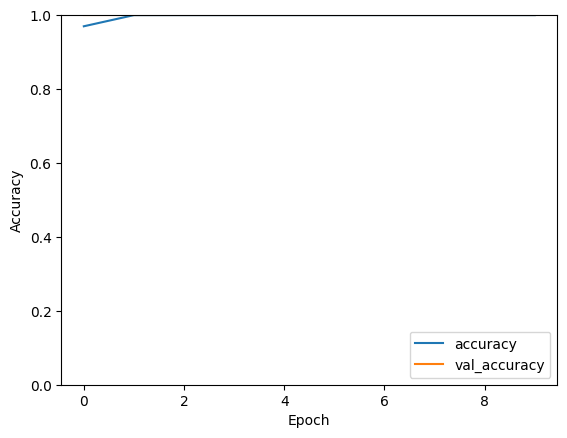

In [37]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


# 5.0 Conclusion and Future Work

In this notebook, we demonstrated how to develop a CNN to detect brain tumors from MRI images. 
Future work could involve exploring more sophisticated model architectures, data augmentation techniques, or different datasets.
